<a href="https://colab.research.google.com/github/Bayhaqieee/GDG_ML_Learning/blob/CV_Classification/Computer%20Vison/Classification_HumanVsHorse_MLGDG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Horse vs. Human Image Classification

### Transfer Learning with MobileNetV2
This notebook demonstrates a binary image classification task using the **transfer learning** approach. We will use the **MobileNetV2** model, which has been pre-trained on the ImageNet dataset, and retrain it for our specific task: distinguishing between images of horses and humans.

The steps we will take include:
1.   Dataset preparation and exploration.
2.   Data preprocessing and augmentation using **ImageDataGenerator**.
3.   Building the model by transferring weights from **MobileNetV2**.
4.   Training and evaluating the model.





In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Dataset Preparation
First, we will download the dataset from Google's servers. This dataset is already divided into two parts:
* **horse-or-human.zip**, Contains images for the training data.
* **validation-horse-or-human.zip**, Contains images for the validation data.

In [ ]:
# Download dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/horse-or-human.zip \
    -O /content/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/validation-horse-or-human.zip \
    -O /content/validation-horse-or-human.zip


--2025-07-30 16:26:37--  https://storage.googleapis.com/learning-datasets/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 64.233.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/content/horse-or-human.zip’

/content/horse-or-h 100%[===================>] 142.65M  22.0MB/s    in 7.7s    

2025-07-30 16:26:46 (18.5 MB/s) - ‘/content/horse-or-human.zip’ saved [149574867/149574867]

--2025-07-30 16:26:46--  https://storage.googleapis.com/learning-datasets/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 64.233.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [applicat

In [ ]:
# Extract ZIP file
local_zip = '/content/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/horse-or-human')
zip_ref.close()

local_zip = '/content/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/validation-horse-or-human')
zip_ref.close()

In [ ]:
base_dir = '/content'
train_dir = os.path.join(base_dir, 'horse-or-human')
validation_dir = os.path.join(base_dir, 'validation-horse-or-human')

train_horses_dir = os.path.join(train_dir, 'horses')
train_humans_dir = os.path.join(train_dir, 'humans')
validation_horses_dir = os.path.join(validation_dir, 'horses')
validation_humans_dir = os.path.join(validation_dir, 'humans')

## Data Exploration
Before proceeding, it's good practice to inspect our dataset. We will count the number of images in each class (horse and human) to ensure the data is balanced and also display a few sample images to get a visual sense of the data we will be working with.

In [ ]:
print(f"Total training horse images: {len(os.listdir(train_horses_dir))}")
print(f"Total training human images: {len(os.listdir(train_humans_dir))}")
print(f"Total validation horse images: {len(os.listdir(validation_horses_dir))}")
print(f"Total validation human images: {len(os.listdir(validation_humans_dir))}")

Total training horse images: 500
Total training human images: 527
Total validation horse images: 128
Total validation human images: 128


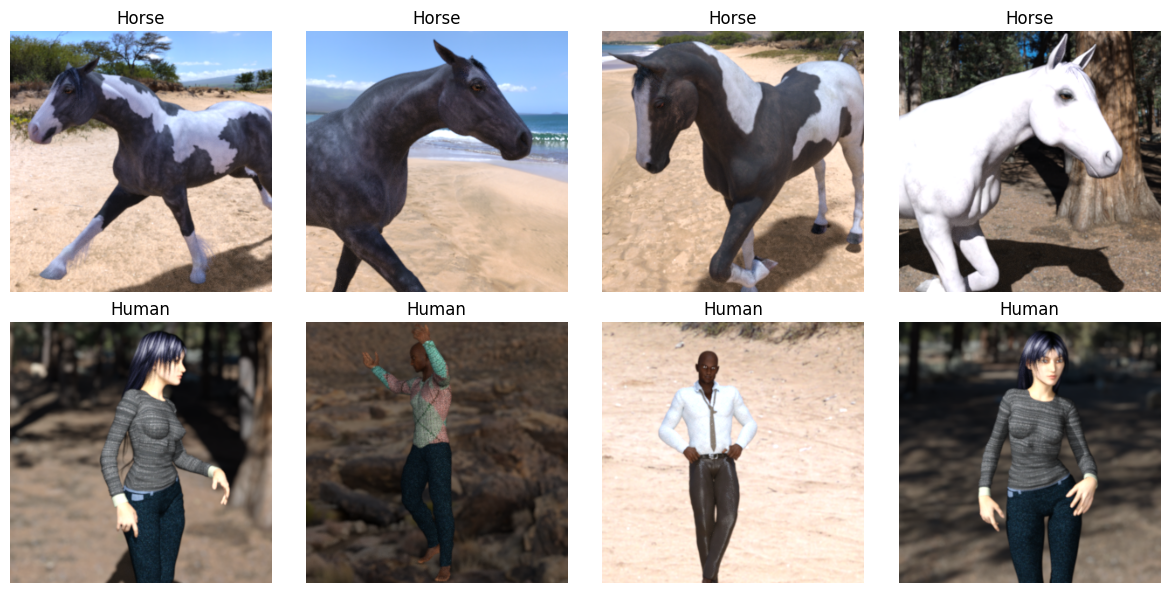

In [ ]:
horse_files = os.listdir(train_horses_dir)[:4]
human_files = os.listdir(train_humans_dir)[:4]

fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i, file_name in enumerate(horse_files):
    img_path = os.path.join(train_horses_dir, file_name)
    img = tf.keras.utils.load_img(img_path)
    axes[0, i].imshow(img)
    axes[0, i].set_title('Horse')
    axes[0, i].axis('off')

for i, file_name in enumerate(human_files):
    img_path = os.path.join(train_humans_dir, file_name)
    img = tf.keras.utils.load_img(img_path)
    axes[1, i].imshow(img)
    axes[1, i].set_title('Human')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Data Preprocessing and Augmentation
We will use the ImageDataGenerator from Keras to do two things:

1. **Preprocessing**, Rescale the pixel values from the [0, 255] range to [0, 1]. This is a standard step to help the model learn more efficiently.

2. **Data Augmentation**, Apply random transformations (rotation, zoom, flip, etc.) to the training images. The goal is to artificially 'multiply' the training data, making the model more robust and less prone to overfitting.

Augmentation is only applied to the training data, not the validation data

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)



In [ ]:
IMG_SIZE = 160
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


## Building the Model (Transfer Learning)
Here, we will build our model architecture using the transfer learning approach.

1. **Load the Base Model**: We load the pre-trained MobileNetV2 model, without its top classification layer (include_top=False).

2. **Freeze the Weights**: We set base_model.trainable = False. This prevents the already 'smart' weights from MobileNetV2 from changing during the initial training phase. We will only train the new layers that we add.

3. **Add a Classification Head**: On top of the base model, we add a few new layers: GlobalAveragePooling2D to flatten the output, followed by Dense, BatchNormalization, and Dropout layers for regularization, and finally a Dense layer with 1 unit and a sigmoid activation for binary classification.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,340,289 (8.93 MB)

 Trainable params: 82,177 (321.00 KB)

 Non-trainable params: 2,258,112 (8.61 MB)

## Compiling the Model
Before training, the model needs to be compiled. Here we define:

* **Optimizer**: The algorithm used to update the model's weights (we'll use Adam).

* **Loss Function**: The function to measure how wrong the model is (binary_crossentropy is suitable for binary classification).

* **Metrics**: The metric to monitor the model's performance (we'll use accuracy).

We also add callbacks like ReduceLROnPlateau to automatically adjust the learning rate and EarlyStopping to halt training if there's no improvement, for efficiency and to prevent overfitting.



In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=1)
EPOCHS = 15

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Training the Model
Now it's time to train our model using model.fit(). The model will learn from the data provided by the train_generator and its performance will be evaluated at the end of each epoch using the validation_generator.

In [ ]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose = 1,
    batch_size = BATCH_SIZE,
    callbacks=[lr_scheduler,es]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 547ms/step - accuracy: 0.8580 - loss: 0.3121 - val_accuracy: 1.0000 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 362ms/step - accuracy: 0.9970 - loss: 0.0299 - val_accuracy: 1.0000 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 360ms/step - accuracy: 0.9970 - loss: 0.0188 - val_accuracy: 1.0000 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 361ms/step - accuracy: 0.9955 - loss: 0.0300 - val_accuracy: 1.0000 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 359ms/step - accuracy: 0.9943 - loss: 0.0237 - val_accuracy: 1.0000 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 366ms/step - accuracy: 0.9934 - loss: 0.0235 - val_accuracy: 1.0000 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 356ms/step - accuracy: 0.9975 - loss: 0.

## Evaluating the Training Results
Visualizing the accuracy and loss curves from the training process is a crucial step for diagnosing the model's performance. We will plot the accuracy and loss for both the training and validation data to see if the model is overfitting (indicated by a large gap between the training and validation curves).

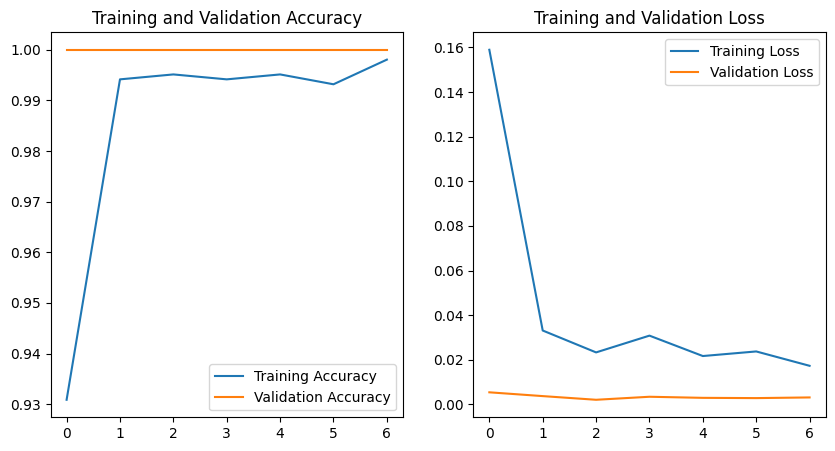

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Making Predictions
As a final step, we will use our trained model to make predictions on a few images from the validation set that it has never seen during training. This demonstrates how the model will perform in a real-world scenario.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


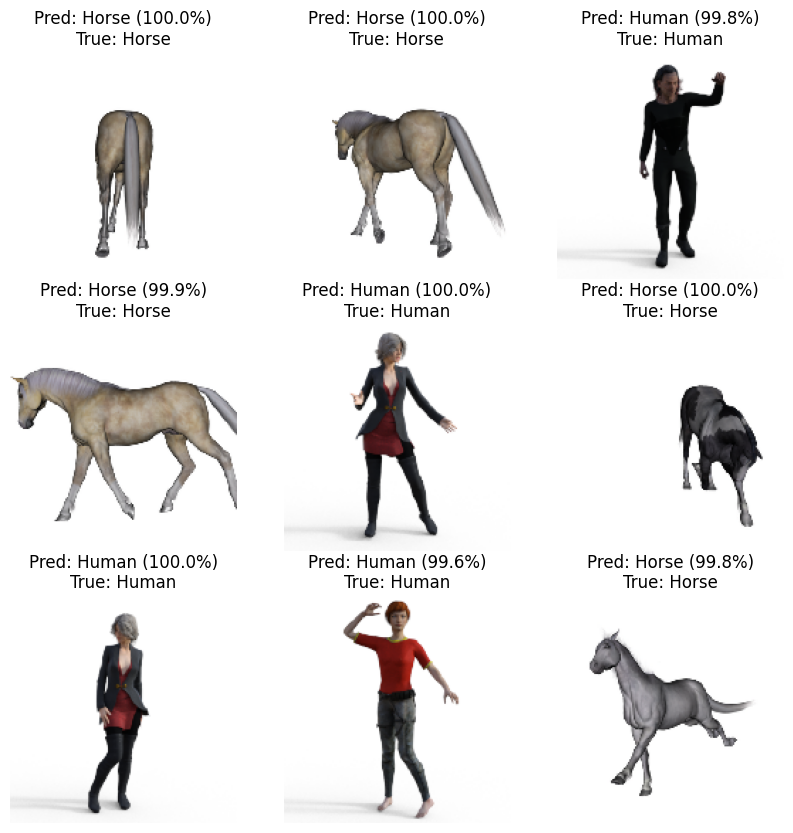

In [ ]:
# Ambil satu batch gambar dan label dari validation generator
image_batch, label_batch = next(validation_generator)

predictions = model.predict(image_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])

    score = predictions[i][0]

    if score > 0.5:
        predicted_label = "Human"
        confidence = score * 100
    else:
        predicted_label = "Horse"
        confidence = (1 - score) * 100

    true_label = "Human" if label_batch[i] == 1 else "Horse"

    plt.title(f"Pred: {predicted_label} ({confidence:.1f}%)\nTrue: {true_label}")
    plt.axis("off")
plt.show()

Saving 01jk9wy2zpxs4bf2ee72az31w4.webp to 01jk9wy2zpxs4bf2ee72az31w4.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


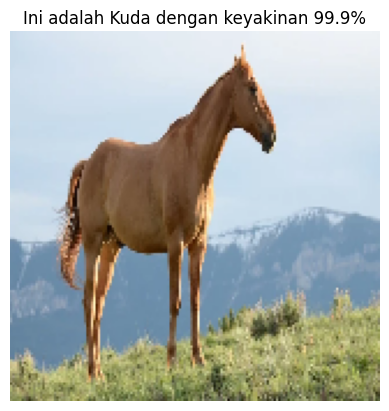

In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

# Fungsi untuk mengunggah, memproses, dan memprediksi gambar
def upload_and_predict():
  # 1. Buka dialog untuk mengunggah file
  uploaded = files.upload()

  # 2. Proses setiap file yang diunggah
  for fn in uploaded.keys():
    path = fn
    img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE)) # Muat & resize gambar

    # Tampilkan gambar yang diunggah
    plt.imshow(img)
    plt.axis('off')

    # 3. Preprocessing gambar
    x = img_to_array(img) # Ubah ke array
    x = np.expand_dims(x, axis=0) # Tambahkan dimensi batch
    x = x / 255.0 # Normalisasi piksel

    # 4. Lakukan prediksi
    prediction = model.predict(x)
    score = prediction[0][0]

    # 5. Tampilkan hasil prediksi
    if score > 0.5:
      result = f"Ini adalah Manusia dengan keyakinan {score*100:.1f}%"
    else:
      result = f"Ini adalah Kuda dengan keyakinan {(1-score)*100:.1f}%"

    plt.title(result)
    plt.show()

# Panggil fungsi untuk memulai
upload_and_predict()

## Saving the Trained Model
After we are satisfied with the model's performance, a crucial final step is to save it to a file. By saving the model, we can load it back anytime in the future to make predictions without having to repeat the entire training process.

We will use the model.save() method. This method saves everything needed in a single package:

* **Model Architecture:** The configuration of the layers we have created.

* **Weights:** The weights learned by the model during the training process.

* **Training Configuration:** The optimizer, loss function, and metrics we used during compilation.

We will save it in the modern Keras format (.keras).

In [ ]:
model_filename = "horse_vs_human_classifier.keras"
model.save(model_filename)

print(f"Model successfully saved at: {model_filename}")

Model successfully saved at: horse_vs_human_classifier.keras
